# Pricing European Options Using Black-Scholes, Binomial Tree, and Monte Carlo Simulations

### Objective
In this project, we implement and compare three popular models used to price European call and put options:
1. Black-Scholes Model (Analytical)
2. Binomial Tree Model (Discrete-Time)
3. Monte Carlo Simulation (Stochastic)

We also analyze the assumptions behind these models and examine their computational efficiency, convergence, and pricing accuracy.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Option Parameters
S = 100      # Current stock price
K = 100      # Strike price
T = 1.0      # Time to maturity (in years)
r = 0.05     # Risk-free interest rate
sigma = 0.2  # Volatility of the underlying asset

# Simulation Parameters
N = 100      # Number of steps (for Binomial Tree)
M = 100000   # Number of simulations (for Monte Carlo)


In [3]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

bs_call = black_scholes_call(S, K, T, r, sigma)
bs_put = black_scholes_put(S, K, T, r, sigma)

print(f"Black-Scholes Call Price: {bs_call:.4f}")
print(f"Black-Scholes Put Price : {bs_put:.4f}")


Black-Scholes Call Price: 10.4506
Black-Scholes Put Price : 5.5735


In [5]:
def binomial_tree_option(S, K, T, r, sigma, N, option_type='call'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Create asset prices at maturity
    prices = np.array([S * (u ** j) * (d ** (N - j)) for j in range(N + 1)])

    # Option payoffs at maturity
    if option_type == 'call':
        option_values = np.maximum(prices - K, 0)
    else:
        option_values = np.maximum(K - prices, 0)

    # Backward induction
    for i in range(N - 1, -1, -1):
        option_values = np.exp(-r * dt) * (p * option_values[1:] + (1 - p) * option_values[:-1])

    return option_values[0]

bt_call = binomial_tree_option(S, K, T, r, sigma, N, option_type='call')
bt_put = binomial_tree_option(S, K, T, r, sigma, N, option_type='put')

print(f"Binomial Tree Call Price (N={N}): {bt_call:.4f}")
print(f"Binomial Tree Put Price  (N={N}): {bt_put:.4f}")


Binomial Tree Call Price (N=100): 10.4306
Binomial Tree Put Price  (N=100): 5.5536


In [6]:
def monte_carlo_option(S, K, T, r, sigma, M, option_type='call'):
    Z = np.random.standard_normal(M)
    ST = S * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * Z)

    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)
    else:
        payoffs = np.maximum(K - ST, 0)

    option_price = np.exp(-r * T) * np.mean(payoffs)
    return option_price
mc_call = monte_carlo_option(S, K, T, r, sigma, M, option_type='call')
mc_put = monte_carlo_option(S, K, T, r, sigma, M, option_type='put')

print(f"Monte Carlo Call Price (M={M}): {mc_call:.4f}")
print(f"Monte Carlo Put Price  (M={M}): {mc_put:.4f}")


Monte Carlo Call Price (M=100000): 10.4507
Monte Carlo Put Price  (M=100000): 5.5249


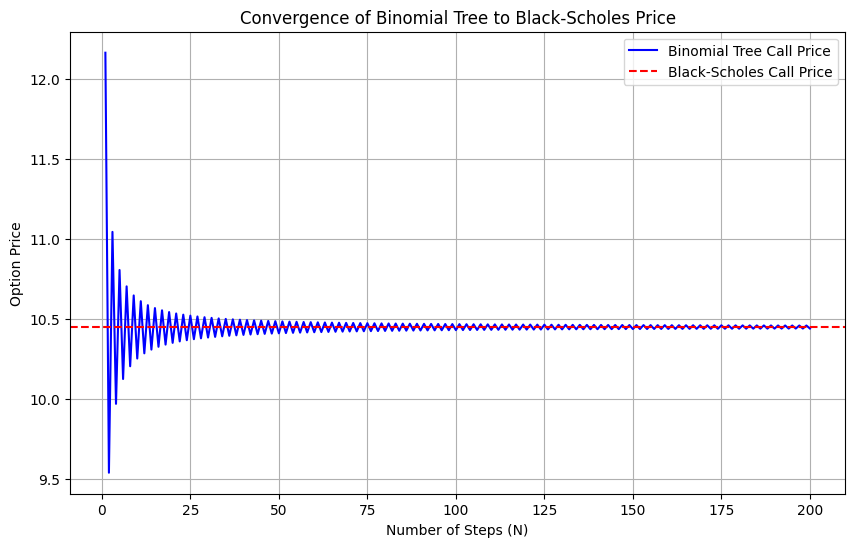

In [7]:
steps = np.arange(1, 201)
bt_call_prices = [binomial_tree_option(S, K, T, r, sigma, n, option_type='call') for n in steps]
bs_call_price = black_scholes_call(S, K, T, r, sigma)

plt.figure(figsize=(10, 6))
plt.plot(steps, bt_call_prices, label='Binomial Tree Call Price', color='blue')
plt.axhline(y=bs_call_price, color='red', linestyle='--', label='Black-Scholes Call Price')
plt.xlabel('Number of Steps (N)')
plt.ylabel('Option Price')
plt.title('Convergence of Binomial Tree to Black-Scholes Price')
plt.legend()
plt.grid(True)
plt.show()


## Black-Scholes Model Assumptions

The Black-Scholes formula provides a closed-form solution for European options but relies on idealized assumptions:

- **Constant Volatility**: The asset's volatility remains constant over time.
- **Lognormal Distribution**: Asset prices follow a geometric Brownian motion.
- **No Arbitrage**: Markets are efficient, and no arbitrage opportunities exist.
- **Frictionless Market**: No transaction costs, taxes, or bid-ask spreads.
- **Constant Interest Rate**: The risk-free rate is fixed for the life of the option.
- **European Style**: Options can only be exercised at maturity.
- **Continuous Trading**: Market participants can adjust positions at every instant.

### Relaxing Assumptions in Other Models

- **Binomial Tree**: Allows for modeling time-dependent parameters and can approximate American-style features.
- **Monte Carlo Simulation**: Useful for modeling complex path-dependent options and variable volatility/rates, at the cost of slower convergence.


In [8]:
def black_scholes_greeks(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return delta, vega

delta, vega = black_scholes_greeks(S, K, T, r, sigma)
print(f"Delta (Call): {delta:.4f}")
print(f"Vega  (Call): {vega:.4f}")


Delta (Call): 0.6368
Vega  (Call): 37.5240


In [9]:
def finite_difference_delta(model_func, S, K, T, r, sigma, epsilon=0.01):
    price_up = model_func(S + epsilon, K, T, r, sigma)
    price_down = model_func(S - epsilon, K, T, r, sigma)
    return (price_up - price_down) / (2 * epsilon)

def finite_difference_vega(model_func, S, K, T, r, sigma, epsilon=0.01):
    price_up = model_func(S, K, T, r, sigma + epsilon)
    price_down = model_func(S, K, T, r, sigma - epsilon)
    return (price_up - price_down) / (2 * epsilon)

fd_delta = finite_difference_delta(black_scholes_call, S, K, T, r, sigma)
fd_vega = finite_difference_vega(black_scholes_call, S, K, T, r, sigma)

print(f"Finite Difference Delta: {fd_delta:.4f}")
print(f"Finite Difference Vega : {fd_vega:.4f}")


Finite Difference Delta: 0.6368
Finite Difference Vega : 37.5210


In [10]:
import pandas as pd

data = {
    'Method': ['Black-Scholes', 'Binomial Tree', 'Monte Carlo'],
    'Call Price': [bs_call, bt_call, mc_call],
    'Put Price': [bs_put, bt_put, mc_put]
}

df = pd.DataFrame(data)
print(df.round(4))


          Method  Call Price  Put Price
0  Black-Scholes     10.4506     5.5735
1  Binomial Tree     10.4306     5.5536
2    Monte Carlo     10.4507     5.5249
